In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

# 讀入股價資料，CP/RI權重資料，並新增欄位以供寫入資料用

In [2]:
df = pd.read_csv('/Users/Kang/Desktop/HW2/CSVs/1_1 Rebalance_NAV.csv', index_col = 'Date')
df_w_CP = pd.read_csv('/Users/Kang/Desktop/BL CP weight_adj.csv', index_col = 0)
df_w_RI = pd.read_csv('/Users/Kang/Desktop/BL RI weight_adj.csv', index_col = 0)
df = df.set_index(pd.to_datetime(df.index))
df_w_CP = df_w_CP.set_index(pd.to_datetime(df_w_CP.index))
df_w_RI = df_w_RI.set_index(pd.to_datetime(df_w_RI.index))

df['NAV_CP'] = np.nan
df['NAV_RI'] = np.nan

# 新增df_CP_unites跟df_RI_units用來儲存之後每個月ETF購買單位數

In [3]:
all_ticker = df_w_CP.columns
all_rebalance_day = df_w_CP.index
df_CP_units = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
df_RI_units = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
df_CP_units = df_CP_units.set_index(pd.to_datetime(df_CP_units.index))
df_RI_units = df_RI_units.set_index(pd.to_datetime(df_RI_units.index))

# 計算NAV_CP, NAV_RI

In [4]:
#用以計算到Rebalance當天的NAV
def caculate_nav(i, tem_count): #計算到第幾個rebalance day
    while tem_count < len(df): #當tem_count等於len(df)時不能跑，而且事實上也已經跑完了
        #對於比第i個權重日期還要早或相同的所有日期
        if all_rebalance_day[i] >= df.index[tem_count]:
            t = all_rebalance_day[i - 1] #是使用上一個rebalance日的權重
            df['NAV_CP'].iloc[tem_count] = sum(df[j].iloc[tem_count] * df_CP_units[j].loc[t] for j in all_ticker) #計算每天的NAV
            df['NAV_RI'].iloc[tem_count] = sum(df[j].iloc[tem_count] * df_RI_units[j].loc[t] for j in all_ticker)
            tem_count += 1
        else:
            break  
    return tem_count

def rebalance_weight(j): #計算到第幾個rebalance day
    t = all_rebalance_day[j]
    for etf in all_ticker:
        df_CP_units[etf][t] = price_to_balance_CP * df_w_CP[etf][t] / df[etf][t] #計算出Rebalance日所有etf的新權重（購買單位）
        df_RI_units[etf][t] = price_to_balance_RI * df_w_RI[etf][t] / df[etf][t] 

In [5]:
price_to_balance_CP = df['NAV'].iloc[0] #begining invest 10000
price_to_balance_RI = df['NAV'].iloc[0] #因為一次要做兩個column的NAV，要有兩個起始投資額，之後分開更新
tem_count = 0

#一開始先將第一個月全部填為10000，因為沒有2009-12的權重可用
rebalance_weight(0)
df['NAV_CP'].loc[:df_w_CP.index[0]] = price_to_balance_CP
df['NAV_RI'].loc[:df_w_RI.index[0]] = price_to_balance_RI
tem_count += len(df.loc[:df_w_CP.index[0]]) #直接越過一月所有日期

#之後在每一個rebalance日之前，都先算出所有NAV，然後用rebalance當天的etf價格，重新分配權重
for day in range(1, len(all_rebalance_day)): #第幾個rebalance day，第0個已經在上面先跑過了，從二月底2010-02-26開始做
    tem_count = caculate_nav(day, tem_count) #將自己循環代入函式，可不斷得到新的斷位點，也就是下次rebalance的當天
    price_to_balance_CP = df['NAV_CP'][tem_count - 1] #因為tem_count加一，需減一才是Rebalance當天的NAV
    price_to_balance_RI = df['NAV_RI'][tem_count - 1]
    rebalance_weight(day)

In [6]:
#從二月底開始的每個月最後一天，套用上個月的權重跟本月權重會有相同的NAV，rebalance的必然
print(sum(df[j].loc['2010-02-26'] * df_RI_units[j].loc['2010-01-29 '] for j in all_ticker))
print(sum(df[j].loc['2010-02-26'] * df_RI_units[j].loc['2010-02-26'] for j in all_ticker))

10160.349747218477
10160.349747218479


In [7]:
#df.loc[(df.index.year == 2010) & (df.index.month == 1)]

In [8]:
df_w_CP

,AGG,EMB,EWT,IVV,JNK,PFF,TLT,VGK,VNQ,VPL,VWO
2010-01-29,0.100000,0.050000,0.105556,0.204167,0.047222,0.045833,0.050000,0.098611,0.101389,0.094444,0.102778
2010-02-26,0.105041,0.050000,0.106721,0.203360,0.051680,0.043279,0.050000,0.094959,0.096640,0.098320,0.100000
2010-03-31,0.100000,0.050000,0.104211,0.198596,0.044386,0.047193,0.052807,0.095789,0.105614,0.100000,0.101404
2010-04-30,0.098353,0.050000,0.101647,0.206589,0.043411,0.050000,0.054942,0.096705,0.095058,0.100000,0.103295
2010-05-28,0.101520,0.050000,0.106079,0.203039,0.043921,0.045441,0.050000,0.104559,0.096961,0.100000,0.098480
2010-06-30,0.101560,0.050000,0.096880,0.206240,0.043760,0.045320,0.050000,0.104680,0.098440,0.100000,0.103120
2010-07-30,0.096955,0.050000,0.106091,0.200000,0.043909,0.053045,0.054568,0.098477,0.095432,0.100000,0.101523
2010-08-31,0.095939,0.050000,0.102707,0.204061,0.047293,0.044586,0.051354,0.100000,0.098646,0.100000,0.105414
2010-09-30,0.097856,0.050000,0.104287,0.202144,0.045713,0.050000,0.046785,0.098928,0.101072,0.100000,0.103215
2010-10-29,0.105523,0.050000,0.101841,0.203682,0.042635,0.048159,0.057365,0.094477,0.100000,0.100000,0.096318


In [9]:
df_w_RI

,AGG,EMB,EWT,IVV,JNK,PFF,TLT,VGK,VNQ,VPL,VWO
2010-01-29,0.098281,0.050000,0.100573,0.200000,0.048854,0.050000,0.047707,0.099427,0.101719,0.102293,0.101146
2010-02-26,0.100000,0.050000,0.102651,0.199116,0.051767,0.050000,0.047349,0.096466,0.100884,0.103534,0.098233
2010-03-31,0.098730,0.050000,0.101270,0.201905,0.050000,0.049365,0.047460,0.098095,0.102540,0.100000,0.100635
2010-04-30,0.098380,0.050000,0.100000,0.202430,0.051620,0.050810,0.046760,0.099190,0.097570,0.100000,0.103240
2010-05-28,0.100000,0.050000,0.102093,0.201047,0.054187,0.046860,0.048953,0.095813,0.097907,0.100000,0.103140
2010-06-30,0.105617,0.050000,0.104213,0.201404,0.047191,0.050000,0.052809,0.094383,0.095787,0.100000,0.098596
2010-07-30,0.103359,0.050000,0.102240,0.201120,0.050000,0.048880,0.047760,0.095521,0.096641,0.100000,0.104479
2010-08-31,0.103103,0.050000,0.098966,0.201034,0.052068,0.050000,0.045863,0.096897,0.097932,0.100000,0.104137
2010-09-30,0.098549,0.050000,0.100726,0.200000,0.051451,0.052903,0.047097,0.097823,0.099274,0.100000,0.102177
2010-10-29,0.098201,0.050000,0.100600,0.201799,0.049400,0.050000,0.047602,0.098801,0.101199,0.100000,0.102398


In [10]:
#df.to_csv('/Users/Kang/Desktop/5_1 NAV.csv')
#df_CP_units.to_csv('/Users/Kang/Desktop/5_2 CP weight.csv')
#df_RI_units.to_csv('/Users/Kang/Desktop/5_3 RI weight.csv')

# 畫圖

Text(0.5, 1.0, 'NAV of portfolio rebalance each month')

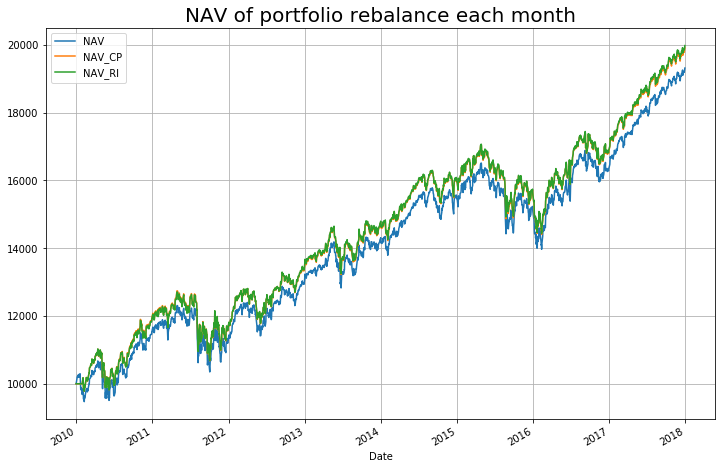

In [11]:
#figsize(12,8)
df.plot(y=['NAV', 'NAV_CP', 'NAV_RI'], figsize=(12,8), grid = True)
plt.title('NAV of portfolio rebalance each month', size = 20)

Text(0.5, 1.0, 'ETF buy units adjust with CP spread view')

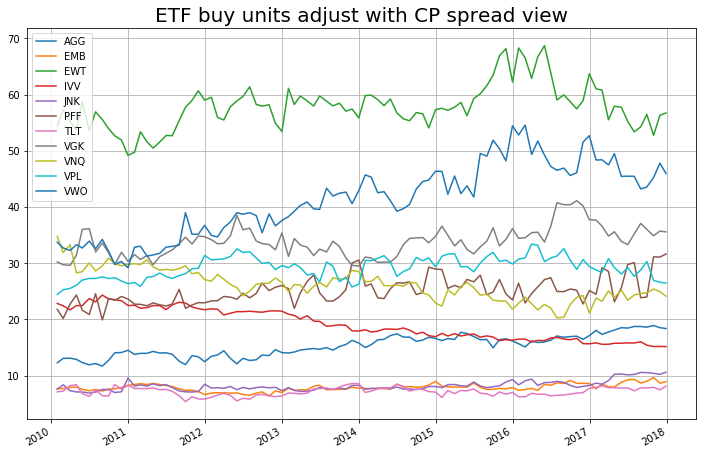

In [12]:
df_CP_units.plot(figsize=(12,8), grid=True)
plt.title('ETF buy units adjust with CP spread view', size = 20)

Text(0.5, 1.0, 'ETF buy units adjust with RI spread view')

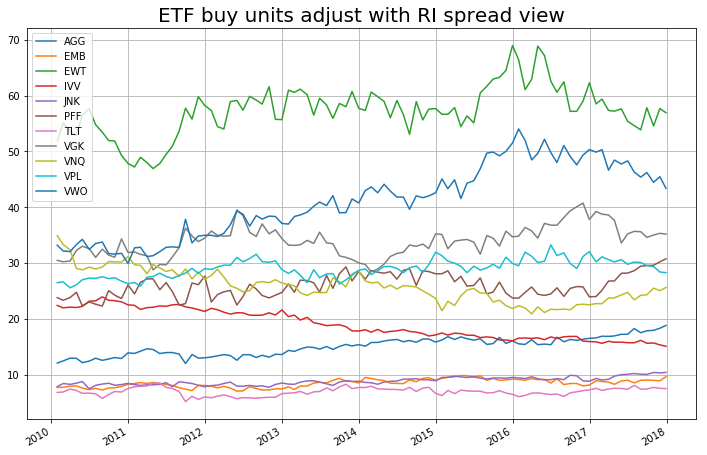

In [13]:
df_RI_units.plot(figsize=(12,8), grid=True)
plt.title('ETF buy units adjust with RI spread view', size = 20)